In [1]:
import sys
import parse as p
import author_network as an
import numpy as np
import networkx as nx
import graphviz as gv
from matplotlib import pyplot as plt
from community import community_louvain
import collections
from node2vec import Node2Vec
p.parse_json('../data/icml2019.json')

### Reading File

In [2]:
temp, temp1 = p.get_paper_count()
authors = temp[0]
counts = temp[1]
sorted_authors = temp1[0]
sorted_counts = temp1[1]

### Author who published the most papers

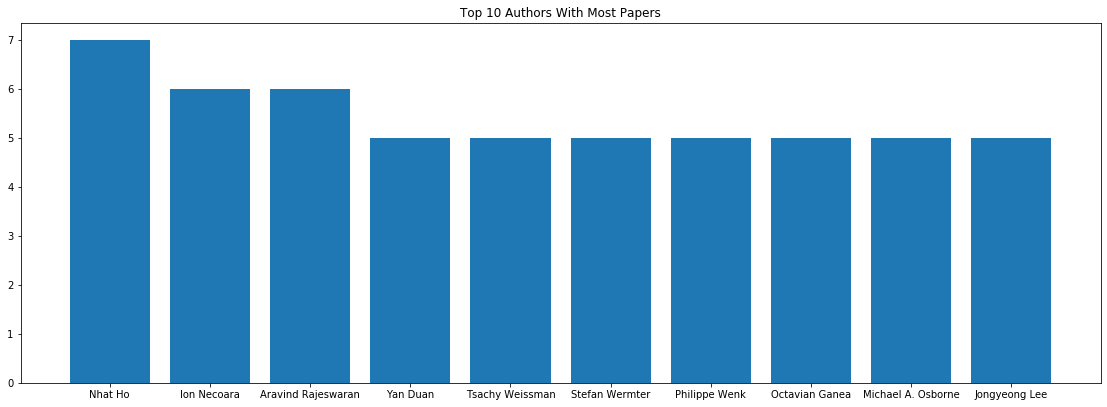

In [3]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(sorted_authors[:10],sorted_counts[:10], width = 0.8)
plt.title('Top 10 Authors With Most Papers')
plt.show()

###  Author who has been working with the most people

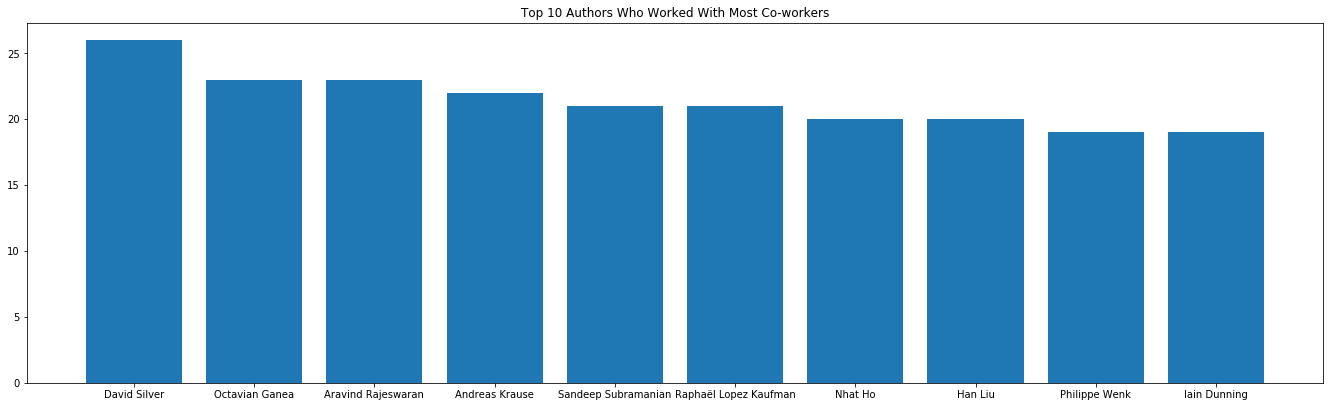

In [4]:
co_count_authors, co_counts = an.co_worker_counts()
fig = plt.figure(figsize=(18, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(co_count_authors[:10],co_counts[:10], width = 0.8)
plt.title('Top 10 Authors Who Worked With Most Co-workers')
plt.show()

### Community Detection (Louvain algorithm)

In [5]:
edges, alone = an.get_edges()
G = nx.MultiGraph()
G.add_edges_from(edges)
G.add_nodes_from(alone)
partition = community_louvain.best_partition(G)


In [6]:
# Adding number of papers attribute
for i in range(len(authors)):
    G.nodes[authors[i]]['papers'] = counts[i]
    


In [7]:
values = [partition.get(node) for node in G.nodes()]
counter = collections.Counter(values)


### Author who has been working with the most research groups

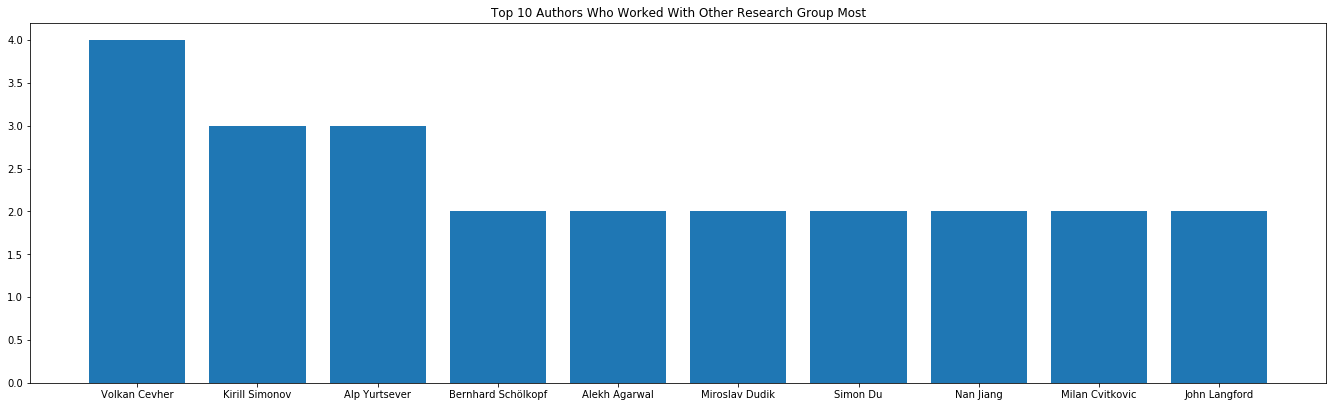

In [8]:
other_group = an.find_other_group(G, values)
fig = plt.figure(figsize=(18, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar([x[0] for x in other_group ][:10], [x[1] for x in other_group ][:10], width = 0.8)
plt.title('Top 10 Authors Who Worked With Other Research Group Most')
plt.show()

### Network Graph - Louvain algorithm

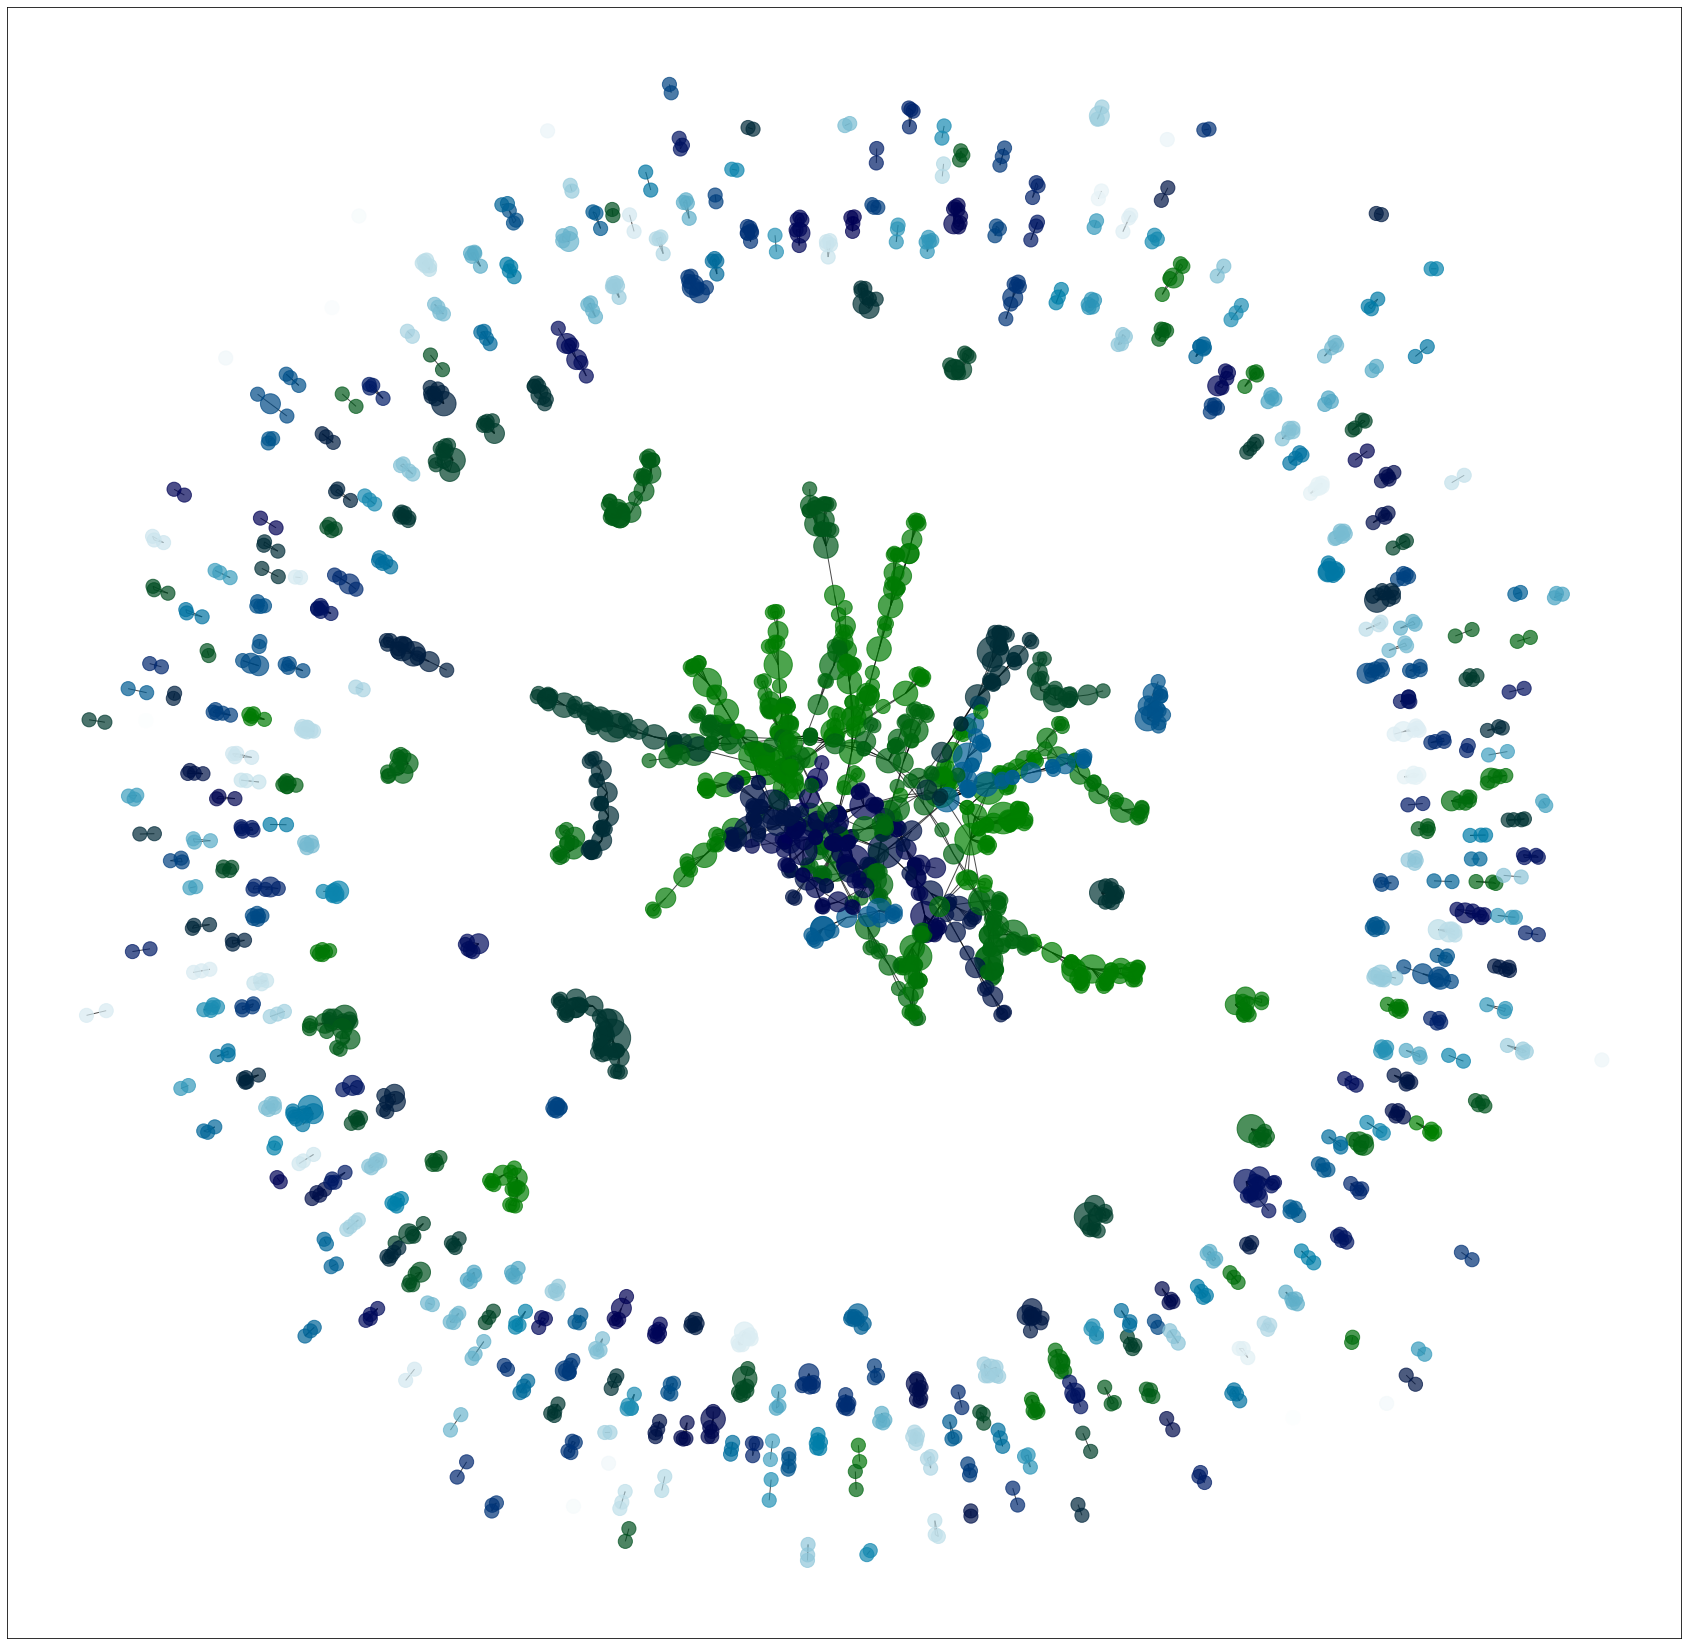

In [9]:
plt.figure(figsize =(30,30))
sp = nx.spring_layout(G)
#node_size = [x for x in G.degree()]
node_size = [200 * nx.get_node_attributes(G, 'papers')[v] for v in G] 
nx.draw_networkx(G, pos=sp, with_labels=False, node_size=node_size,
                 node_color=values, alpha=0.7,cmap = plt.cm.ocean)
# plt.axes('off')
plt.show()

### Network Graph - node2vec and k-means algorithm

In [10]:
node2vec = Node2Vec(graph=G, # target graph
                    dimensions=50, # embedding dimension
                    walk_length=10, # number of nodes in each walks 
                    p = 1, # return hyper parameter
                    q = 0.0001, # inout parameter, q값을 작게 하면 structural equivalence를 강조하는 형태로 학습됩니다. 
                    weight_key=None, # if weight_key in attrdict 
                    num_walks=2000, 
                    workers=1,
                   )
# 대략 walk들이 어떻게 발생하는지를 아래처럼 볼 수도 있습니다. 
for i, each_walk in enumerate(node2vec.walks):
    print(f"{i:0>2d}, {each_walk}")
    if i>1:
        break
# 발생한 walk를 사용해서 학습을 시켜봅니다. 
# 여기서 fitting할때 사용하는 argument는 gensim의 word2vec과 같습니다. 
# 단 학습시킨 것을 model1처럼 어디에 집어넣어줘야 하는 것 같네요. 여기서 p나 q값을 조절하기는 어려운 것 같습니다. 
model1 = node2vec.fit(window=2)



Generating walks (CPU: 1): 100%|██████████| 2000/2000 [24:33<00:00,  1.36it/s]


00, ['Markus Rabe', 'Stewart Wilcox', 'Sarah Loos', 'Stewart Wilcox', 'Kshitij Bansal', 'Markus Rabe', 'Christian Szegedy', 'Stewart Wilcox', 'Kshitij Bansal', 'Stewart Wilcox']
01, ['Dale Schuurmans', 'Nicolas Papernot', 'Geoffrey Hinton', 'Nicolas Papernot', 'Simon Kornblith', 'Dale Schuurmans', 'Chen Liang', 'Marc G. Bellemare', 'Zafarali Ahmed', 'Nicolas Le Roux']
02, ['Irad Yavneh', 'Ronen Basri', 'Meirav Galun', 'Irad Yavneh', 'Daniel Greenfeld', 'Irad Yavneh', 'Daniel Greenfeld', 'Ronen Basri', 'Irad Yavneh', 'Daniel Greenfeld']


In [13]:
print("a")

a


In [14]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans


In [21]:
print("a")
model1 = node2vec.fit(window=10)
# kmeans clustering을 진행해줍니다. 




a


In [22]:
K = 5
print("0")
kmeans = KMeans(n_clusters=K, random_state=0).fit(model1.wv.vectors)
print("1")
# node의 cluster 부분을 attrdict에 업데이트해줍니다. 
for n, label in zip(model1.wv.index2entity, kmeans.labels_):
    G.nodes[n]['label'] = label

print("2")


0
1
2


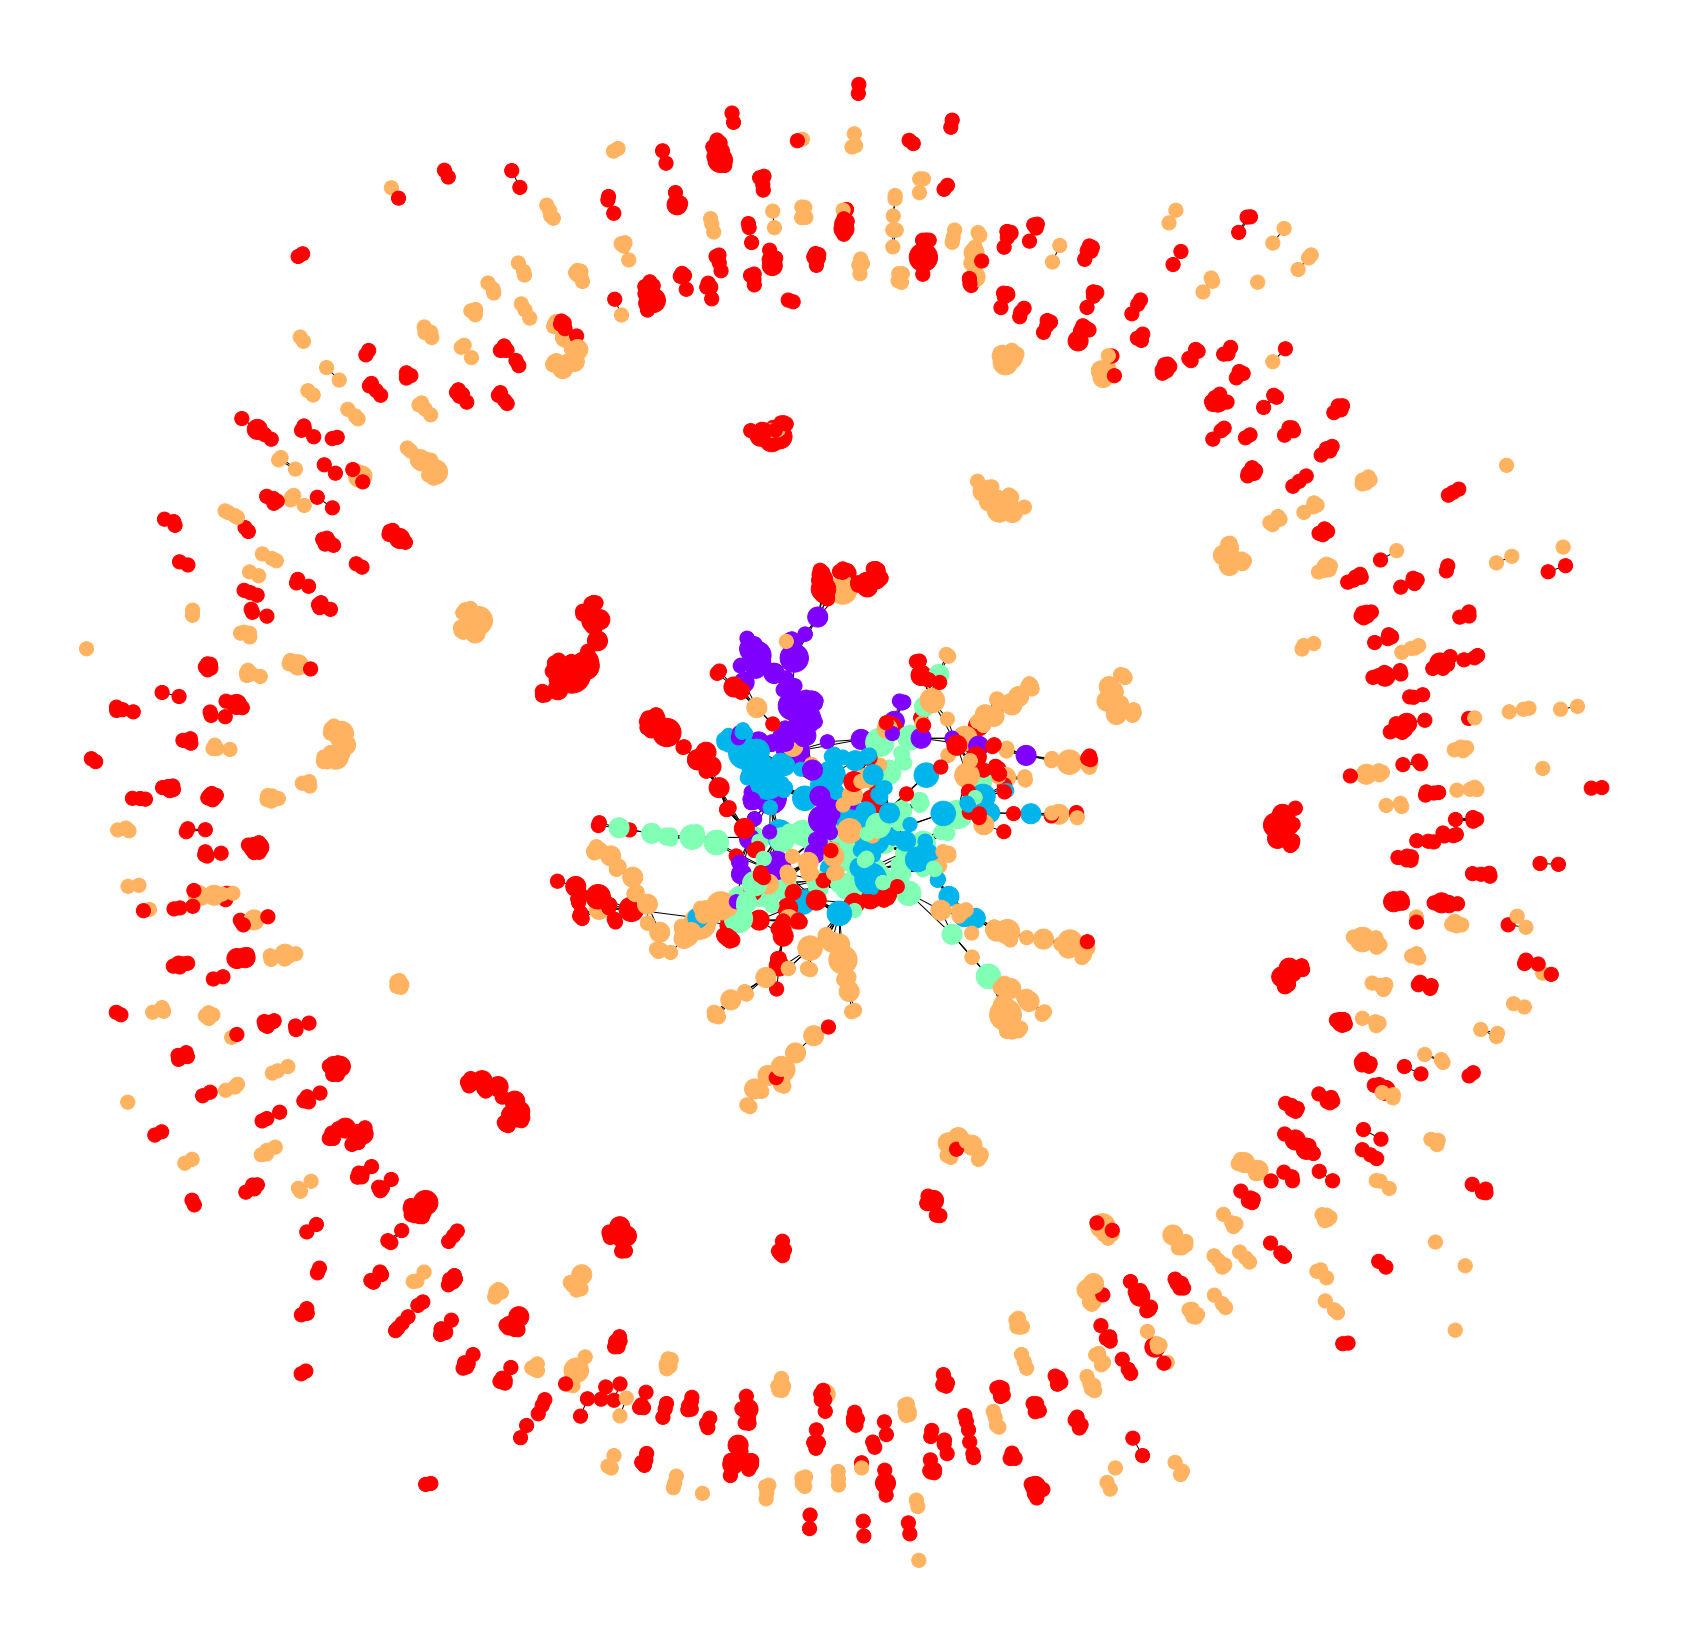

In [26]:
# 그림을 그려줍니다.
plt.figure(figsize=(30, 30))
nx.draw_networkx(G, pos=nx.layout.spring_layout(G), node_size=node_size,
                 node_color=[n[1]['label'] for n in G.nodes(data=True)], with_labels=False,
                 cmap=plt.cm.rainbow
                )
plt.axis('off')
plt.show()




In [29]:
G.nodes()


NodeView(('Gabriele Abbati', 'Philippe Wenk', 'Michael A. Osborne', 'Andreas Krause', 'Bernhard Schölkopf', 'Stefan Bauer', 'Axel Abels', 'Diederik Roijers', 'Tom Lenaerts', 'Ann Nowé', 'Denis Steckelmacher', 'Bryan Perozzi', 'Sami Abu-El-Haija', 'Amol Kapoor', 'Nazanin Alipourfard', 'Kristina Lerman', 'Hrayr Harutyunyan', 'Greg Ver Steeg', 'Aram Galstyan', 'Clement Canonne', 'Jayadev Acharya', 'Himanshu Tyagi', 'Chris De Sa', 'Dylan Foster', 'Karthik Sridharan', 'Ziteng Sun', 'Roy Adams', 'Yuelong Ji', 'Xiaobin Wang', 'Suchi Saria', 'Adrian Weller', 'Tameem Adel', 'Abhijin Adiga', 'Chris J Kuhlman', 'Madhav Marathe', 'S Ravi', 'Anil Vullikanti', 'Brian Bullins', 'Naman Agarwal', 'Xinyi Chen', 'Elad Hazan', 'Karan Singh', 'Cyril Zhang', 'Yi Zhang', 'Ashish Agarwal', 'Sham Kakade', 'Alekh Agarwal', 'Miroslav Dudik', 'Zhiwei Steven Wu', 'Chen Liang', 'Rishabh Agarwal', 'Dale Schuurmans', 'Mohammad Norouzi', 'Brian Trippe', 'Raj Agrawal', 'Jonathan Huggins', 'Tamara Broderick', 'Nicolas L